# Informe nº2
    Notas: toma de fotos cielo con la cámara. Debido a que OpenCV trata las imagenes como matrices BGR y matplotlib las intepreta como RGB, el color de las imágenes no se corresponde con la realidad.
    Fecha: 02/05/2020

   ### Comunicaión con la cámara y toma de fotos del cielo        
    De forma breve, se explicará el método utilizado para la comunicaión con la cámara y la toma de fotos del cielo   

   ### Pre-procesado de las imágenes
    Antes de comenczar a trabajar con las imágenes se les aplica un máscara con la que eliminamos las zonas de la imágenes que no nos son útiles.

   ### Aplicación de los métodos vistos en el infome nº1 
    Ligeras modificaciones de los métodos vistos del informe anterior para adaptarse a las características de la cámara instalada. También se proponen nuevos métodos experimentales.
    
   ### Posición solar y porcentaje de nubosidad 
    
   #### Obtención de la posición solar y comparación con la real
    Utilizanod como base los método de detección solar anteriormente mencionados, podemos obtener las posición del sol en la imagen. Una vez obtenida la posiciñon del sol en la imagen, nos disponemos a compararla con la posición del sol teórica, con el fin de observar si existe alguna variación en el zenith de la imagen(centro de la imagen) y el zenith real, es decir, la cámara esté desnivelada. Por otro lado, se ha realizado también el ajuste del azimuth real con el de la imagen.
        
   #### Porcentaje de cielo que se encuentra cubierto por nubes
    Una vez disponemos de la máscara que nos indica el cielo que está cubierto por nubes, resulta sencillo calcular el cielo( que podemos ver) que se encuentra cubierto por nubes.

In [1]:
!pip install opencv-python
!pip install matplotlib
!pip install pvlib
!pip install pyephem
!pip install pandas
!pip install datetime

import cv2
import numpy as np
import pandas as pd
import datetime as dt
import math
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pvlib as pv
from datetime import datetime as dt
from glob import glob

In [2]:
# Lectura de todas las fotos del cielo
path_fotos = 'Fotos Cielo/'
images = glob(path_fotos + '*.jpg')

### Comunicaión con la cámara y toma de fotos del cielo 
     Para la comunicación con la cámara se ha utilizado la librería OpenCV, ya que dispone de las funciones necearias para realizar la tarea de toma de fotos. El protocolo por el que se comunican es RTSP(Real Time Streaming Protocol). Debido a que nuestro objetivo es el de tomar fotos del cielo para estimar la radiación difusa, sólo nos interesen los memonetos en el que el sol se encuentra en el cielo, es decir, entre su salida y su puesta. Para conseguir esto, utilizamos la librería PVLib para cálcular las horas en las que se produce en amanecer y anochecer. En el siguiente script se puede ver la sencillez del código:

### Pre-procesado de las imágenes
     Antes de comenzar con el procesado de las imágenes debemos quitar las partes de la imágenes que no vayamos a necesitar, p.ej.: ajustar la zona visible a una circunferencia, eliminar objetos cercanos que se puedan ver, etc. Para ello, tomaremos una imagen como patrón, de la cuál obtenemos las máscaras que aplicaremos a la imagen en bruto. Para obtener una imagen resultante con la que podemos comenzar a trabajar.

In [3]:
# Lecutura de la imagen patron
path_fotos_patron = 'Fotos Cielo/Patron/'
img_patron = cv2.imread(path_fotos_patron + 'imagen_patron.jpg', cv2.IMREAD_COLOR)

# Máscara circular, para corregir los efectos de la lente en en los bordes (ajuste incorrecto y paso de luz en bordes)
def mascara_inicial():
    mask_circulo = img_patron.copy()
    
    # Dibujo de círculo con diámetro igual a la longitud del lado mayor
    X, Y, colores = mask_circulo.shape
    centro = (int(Y/2), int(X/2))
    R = int(Y/2)
    cv2.circle(mask_circulo, centro, R, color=(255,255,255), thickness=-1)
    
    # Conversión a escala de grises
    mask_circulo = np.uint8(cv2.cvtColor(mask_circulo, cv2.COLOR_BGR2GRAY))
    mask_circulo = cv2.inRange(mask_circulo, 255, 255)
    
    return mask_circulo


# Máscara para determinar zona de cielo visible con la cámara
def mascara_cielo():
    img_proc = cv2.bitwise_and(img_patron, img_patron, mask=mascara_inicial())
    
    # Se aplican unos rangos, obtenidos experimentalmente, para eliminar los objetos que se encuentren obstruyendo
    # la imagen del cielo
    blue = cv2.inRange(img_proc[:,:,0], 0, 130)
    green = cv2.inRange(img_proc[:,:,1], 0, 110)
    red = cv2.inRange(img_proc[:,:,2], 0, 60)
    
    mask_cielo = cv2.bitwise_or(blue, green)
    mask_cielo = cv2.bitwise_or(mask_cielo, red)

    mask_cielo = cv2.bitwise_not(np.uint8(mask_cielo))
    return mask_cielo

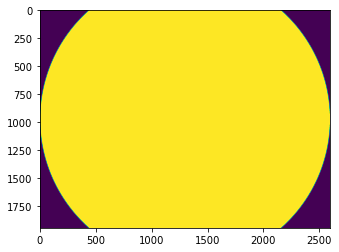

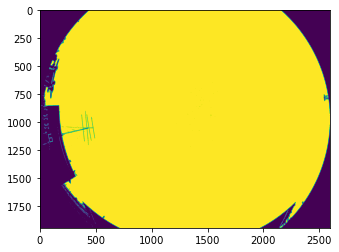

In [25]:
# Máscara que aplicamos a la imagen en bruto
plt.figure(1)
plt.imshow(mascara_inicial())
plt.figure(2)
plt.imshow(mascara_cielo())

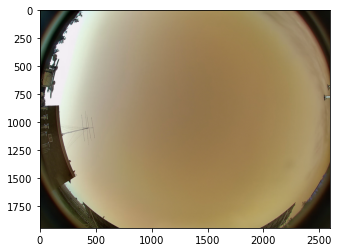

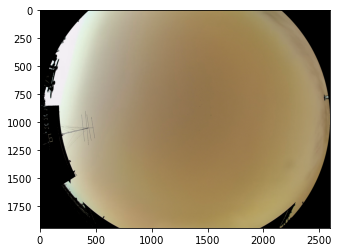

In [5]:
# Ejemplo de imagen en brutro frente a imagen aplicando los filtros
mask_cielo = mascara_cielo()
img_patron_proc = cv2.bitwise_and(img_patron, img_patron, mask=mask_cielo)

plt.figure(1)
plt.imshow(img_patron)
plt.figure(2)
plt.imshow(img_patron_proc)

   ### Aplicación de los métodos vistos en el infome nº1 

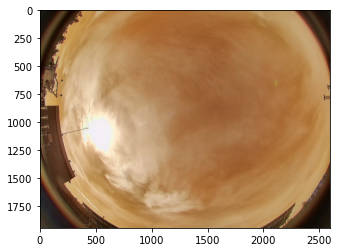

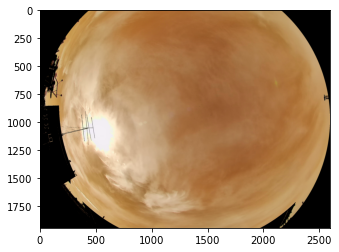

In [6]:
# Preparación de la imágen con la que trabajaremos
select_image = images[1]
img_bgr = cv2.imread(select_image, cv2.IMREAD_COLOR)
img_proc = cv2.bitwise_and(img_bgr, img_bgr, mask=mask_cielo)

Blue_channel = img_proc[:,:,0]
Green_channel = img_proc[:,:,1]
Red_channel = img_proc[:,:,2]

plt.figure(1)
plt.imshow(img_bgr)
plt.figure(2)
plt.imshow(img_proc)

   #### Métodos de detección del sol
       Se exponen los resultados obtenidos con algunos de los métodos explicados en el informe anterior, aplciados a las imágenes obtenidas de la cámara cielo.

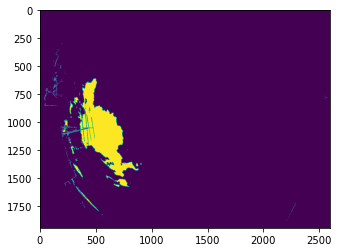

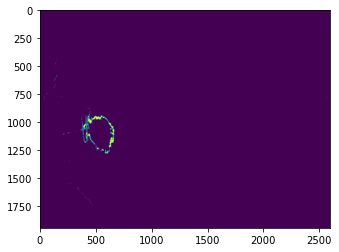

In [7]:
# Método utilizando el canal verde
HBP = cv2.inRange(Green_channel, 200, 255)
CSP = cv2.inRange(Green_channel, 245, 255)

plt.figure(2)
plt.imshow(HBP)
plt.figure(3)
plt.imshow(CSP)

    Como vimos en el informe nº1 este era uno de los mejores métodos a la hora de detectar el sol, por desgracia con las imágenes de la cámara cielo es un método deficiente. Podemos sacar cómo conlcusion que este tipo de métodos son muy dependientes de las cáracterísticas tanto de la imágen, como de la propia cámara.

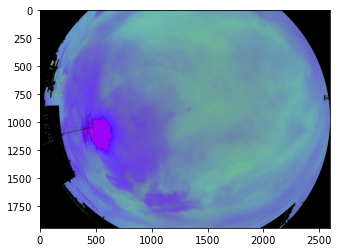

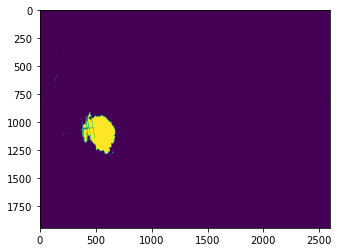

In [8]:
# Método utilizando en modelo HSV
img_hsv = cv2.cvtColor(img_proc, cv2.COLOR_BGR2HSV)
H = img_hsv[:,:,0]
S = img_hsv[:,:,1]
V = img_hsv[:,:,2]

condS = cv2.inRange(S, 0, 40)
condV = cv2.inRange(V, 230, 255)
mask_hsv = cv2.bitwise_and(condS, condV)
            
plt.figure(1)
plt.imshow(img_hsv)
plt.figure(2)
plt.imshow(mask_hsv)

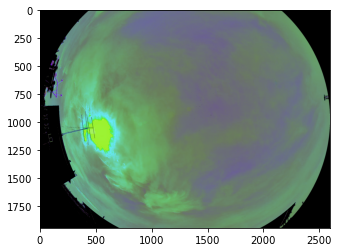

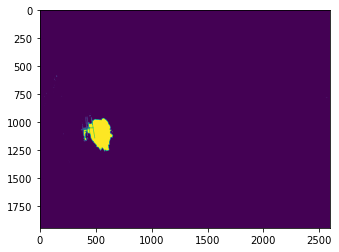

In [9]:
# Método utilizando en modelo HLS
img_hls = cv2.cvtColor(img_proc, cv2.COLOR_BGR2HLS)
H = img_hls[:,:,0]
L = img_hls[:,:,1]
S = img_hls[:,:,2]

mask_hls = cv2.inRange(L, 240, 255)
            
plt.figure(1)
plt.imshow(img_hls)
plt.figure(2)
plt.imshow(mask_hls)

    Los resultados obtenidos en ambos métodos son satisfactorios, detectanto el sol incluso cuando este se encuentra tras una nube poco densa. Se ha decidido que de ahora en adelante de utilizará el modelo HLS, debido a que se basa en un modelo más simple: cuando se alcanza un cierto umbral de luminosidad(L), se considera un pixel correspondiente al sol. A parte de presentar mejores resultados en determinadas circunstancias.

   #### Métodos de detección de nubes
    Al igual que en el caso de la detección del sol, se exponen a continuación los resultados obtenidos con los métodos del informe nº1.
    Hay de destacar que algunos de los métodos propuestos a coninuación detectan nubes o parte de cielo libre de nubes, esto es indiferente, ya que podemos pasar de una máscara a otra sin mayor problema.

C:\Users\nitra\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


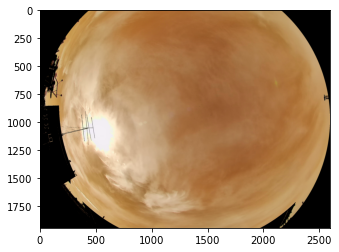

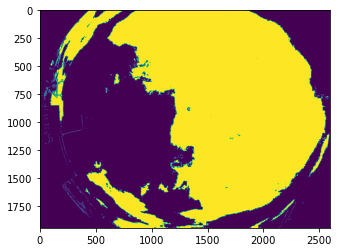

In [10]:
# R/B ratio
RB = Red_channel/Blue_channel
mask_RB = cv2.inRange(RB, 0, 0.47) # Esta función crea una máscara si los valores de RB se encuentran entre 0 y 0.47

mask_RB = cv2.bitwise_and(mask_RB, mask_RB, mask=mask_cielo)
res = cv2.bitwise_and(img_proc, img_proc, mask=np.uint8(mask_RB))

plt.figure(1)
plt.imshow(img_proc)
plt.figure(2)
plt.imshow(mask_RB)

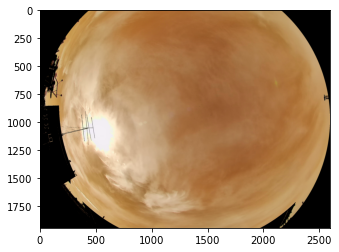

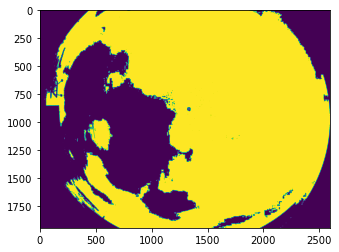

In [11]:
#  R-B ratio
R_B = Blue_channel - Red_channel
mask_R_B = cv2.inRange(R_B, 90, 255)

mask_R_B = cv2.bitwise_and(mask_R_B, mask_R_B, mask=mask_cielo)
res = cv2.bitwise_and(img_proc, img_proc, mask=np.uint8(mask_R_B))

plt.figure(1)
plt.imshow(img_proc)
plt.figure(2)
plt.imshow(mask_R_B)

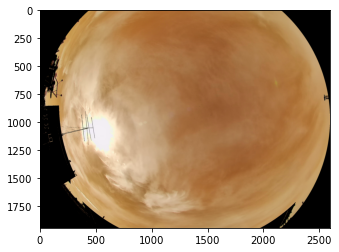

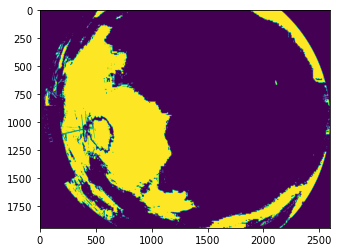

In [12]:
# Criterio Multi-color (Se puede ver que este método detecta la parte de cielo que se encuentra cubierta por nubes)
B_R = cv2.inRange(Blue_channel - Red_channel, 30, 255)
B_G = cv2.inRange(Blue_channel - Green_channel, 0, 40)
B = cv2.inRange(Blue_channel, 160, 255)

mask_MC = cv2.bitwise_and(B_R, B_G)
mask_MC = cv2.bitwise_and(mask_MC, B)
mask_MC = cv2.bitwise_and(mask_MC, mask_MC, mask=mask_cielo)
res = cv2.bitwise_and(img_proc, img_proc, mask=mask_MC)

plt.figure(1)
plt.imshow(img_proc)
plt.figure(2)
plt.imshow(mask_MC)

    Como podemos ver el resultado de la mayoría de los métodos es similar. En todos los casos se detectan las nubes que tiene una densidad elevada, el problema se encuentra en las nubes de poca densidad.
    Observando lo métodos anteriores se propone un método híbrido que mezcla algunos de los meétodos anteriores con el fin de obtener un resultados más próximo a la realidad.

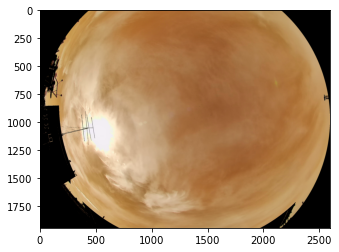

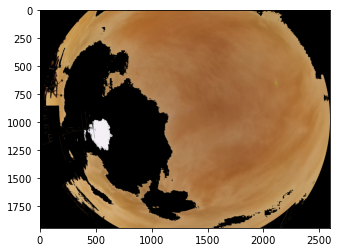

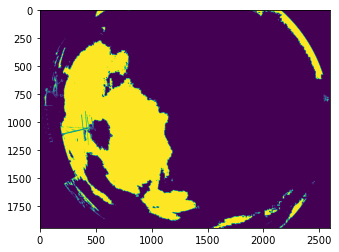

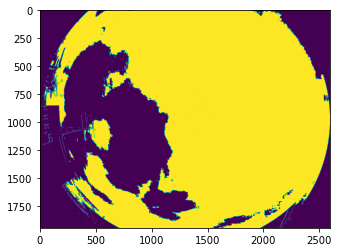

In [13]:
# Método propio:
# Canal verde utilizado por su sensibilidad, especialmente útil en zonas cercanos al sol
mask_green = cv2.inRange(Green_channel, 0, 140)
# Canal rojo, por el color de cielo(azul), su presencia es apreciable solamente en el disco solar y en las nubes
mask_red = cv2.inRange(Red_channel, 0, 70)
# Método R-B, útil por el color de las nubes, ya que limita a diferencia entre los canales R y B
mask_R_B = cv2.inRange(R_B, 90, 255)

mask_clear_sky = cv2.bitwise_or(mask_R_B, mask_green)
mask_clear_sky = cv2.bitwise_or(mask_clear_sky, mask_red)
mask_clear_sky = cv2.bitwise_and(mask_clear_sky, mask_clear_sky, mask=mask_cielo)

mask_cloud = cv2.bitwise_not(mask_clear_sky)
mask_cloud = cv2.bitwise_and(mask_cloud, mask_cloud, mask=mask_cielo)
res = cv2.bitwise_and(img_proc, img_proc, mask=np.uint8(mask_clear_sky))


plt.figure(1)
plt.imshow(img_proc)
plt.figure(2)
plt.imshow(res)
plt.figure(3)
plt.imshow(mask_cloud)
plt.figure(4)
plt.imshow(mask_clear_sky)

#### Obtención de la posición solar y comparación con la real
    Antes de empezar con las comparación, hay que mencionar que la relación que existe entre las coordenadas de la imagen y las de la realidad:
        En el caso de los puntos que se encuentran en un mismo ángulo zenital(en la realidad), estos, en el espacio de la imagen,se encuntran en una circunferencia concentrica con la imagen. La relación entre el ángulo zenital y el radio de la circunferencia es simple: zenith/90 = radio_circun/Radio_imagen. Para más información, ver la bibliografía.
        
    Para poder realizar la comparación, lo primero es ajustar el azimuth en el imagen. Hemos tomado como referencia el poste de la antena de se puede ver la parte izquierda de la imágen:

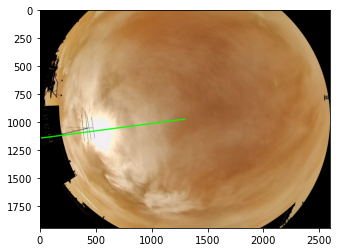

In [14]:
# Variables relativas al tamaño de la imagen
X, Y, canales = img_proc.shape
centro = (int(Y/2), int(X/2))
R = int(Y/2)

# Transformación de coordenadas reales a coordenadas de la imagen de la posición del sol
azimuth_antena_imagen = 187.5

pnt_x = int(centro[0] + R * np.cos(azimuth_antena_imagen / 180 * np.pi))
pnt_y = int(centro[1] - R * np.sin(azimuth_antena_imagen / 180 * np.pi))

# Azimuth
img_antena_azimuth = img_proc.copy()
cv2.line(img_antena_azimuth, centro, (pnt_x, pnt_y), color=(0,255,0), thickness=10)
plt.figure(1)
plt.imshow(img_antena_azimuth)

    Observamos que el azimth en el que se encuentra la antena es de 187º, pero realizando los cálclo, con la ayudad e Google MAPS, obtenemos que el azimth real es de 100.52º, con lo que procedemos a corregir este error:
   * offset_azimuth = 187 - 100.52
   * azimuth_imagen = azimuth + offset_azimuth
   
    A continuación nos disponemos a calcular la posición del sol, tanto teórica(con el uso de la librería pvlib), como la observada en la imagen:

In [15]:
# POSICIÓN DEL SOL TEÓRICA
# Se crea la lista con las horas de las que se desea obtener a información del sol
# Esta lista se formas con las horas obtenidas de las imganes que se han importado
info_images = {}
dates = []
for elem in images:
    fecha = dt.strptime(elem.split('\\')[1].split('_')[2].split('.')[0], '%Y-%m-%d-%Hh%Mmin')
    fecha = pd.Timestamp(fecha, tz = 'Europe/Madrid')
    info_images[elem] = fecha
    dates.append(fecha)

    
# Posición de la cámara
# Longitud: 40 27 12.5 N   40.453472
# Latitud:   3 43 37.3 W  -3.727028
Latitud = 40.453472
Longitud = -3.727028
Altitud = 650

# Se crea el objeto que vamos a utilizar para obtener la posicón del sol
Cam_Location = pv.location.Location(Latitud, Longitud, tz='Europe/Madrid', altitude=Altitud)
times = pd.DatetimeIndex(dates, tz='Europe/Madrid')

# Dataframe con los valores obtenidos
solar_pos = Cam_Location.get_solarposition(times)

solar_pos.loc[info_images[select_image]]

apparent_zenith       54.949540
zenith                54.971684
apparent_elevation    35.050460
elevation             35.028316
azimuth               98.278065
equation_of_time       3.316652
Name: 2020-05-05 10:21:00+02:00, dtype: float64

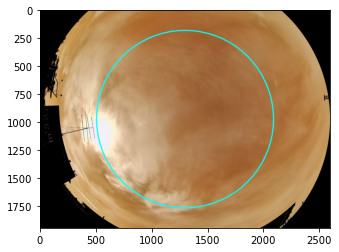

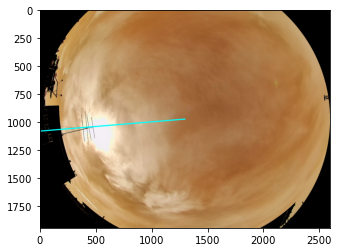

In [16]:
# Se crean las imagenes que se en las que se van a dibujar los ángulos zenitales y azimutales
img_zenith = img_proc.copy()
img_azimuth = img_proc.copy()

# Se obitne la posición del sol en el momento de la toma de la imágen
zenith = solar_pos.loc[info_images[select_image]]['zenith']
azimuth = solar_pos.loc[info_images[select_image]]['azimuth']

# Para calibrar azimuth: antena en parte izq de la imagen: ángulo -> 187 en imagen, ángulo -> 100.52 en la realidad,
# obtenido con Google Maps, mirar notas
offset_azimuth = 187 - 100.52
azimuth_imagen = azimuth + offset_azimuth

# Variables relativas al tamaño de la imágen
X, Y, canales = img_proc.shape
centro = (int(Y/2), int(X/2))
R = int(Y/2)

# Transformación de coordenadas reales a coordenadas de la imágen de la posición del sol
radio_teorico = int(zenith / 90 * R)
pnt_x = int(centro[0] + R * np.cos(azimuth_imagen / 180 * np.pi))
pnt_y = int(centro[1] - R * np.sin(azimuth_imagen / 180 * np.pi))

# Zenith
cv2.circle(img_zenith, centro, radio_teorico, color=(0,255,255), thickness=10)
plt.figure(1)
plt.imshow(img_zenith)

# Azimuth
cv2.line(img_azimuth, centro, (pnt_x, pnt_y), color=(0,255,255), thickness=10)
plt.figure(2)
plt.imshow(img_azimuth)

A: 42668.00
L: 1228.03
C: 0.36


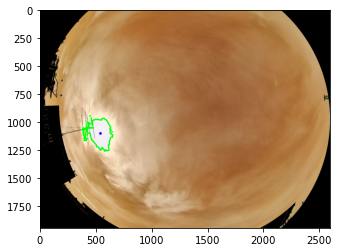

In [17]:
# POSICIÓN DEL SOL EN LA IMAGEN
# Se obtiene los contornos de lá máscara HLS para obtener la posición del sol
mask_hls_cnt = cv2.medianBlur(mask_hls.astype(np.uint8),3)
cnt, hierarchy = cv2.findContours(mask_hls_cnt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
circumsolar_img = img_proc.copy()
cv2.drawContours(circumsolar_img, cnt, -1, [0,255,0], 10, hierarchy=hierarchy)

# Se obtiene el contorno de mayor area y se calcula su circularidad, C,
# se ha supuesto que el contorno de mayor área corresponderá al sol
A = 0.0
for i in cnt:
    temp = cv2.contourArea(i)
    if temp > A:
        A = temp
        L = cv2.arcLength(i, True)
        max_cnt = i

C = 4 * np.pi * A / L**2

print('A: {:.2f}'.format(A))
print('L: {:.2f}'.format(L))
print('C: {:.2f}'.format(C))

# Cálculo del centroide con los momentos del controne de mayor tamaño de la imágen
moments = cv2.moments(max_cnt)
# (x,y) *Ver bibliografía para conocer el origen de la fórmula
centroide = (int(moments['m10']/moments['m00']), int(moments['m01']/moments['m00']))

#Dibujo del centroide
cv2.circle(circumsolar_img, centroide, 2, color=(0,0,255), thickness=20)
plt.figure(1)
plt.imshow(circumsolar_img)

    En un caso normal, con una circularidad tan baja, se consideraría que el sol está tapado por nubes. Con lo que esta no sería una forma váida de obtener su posición, sino que tendríamos que obtenerla de forma teórica. Dejaremos esto a un lado, ya que el objetivo es mostrar los métodos por separado.
    Finalmente, podemos obtener los ángulos zenitales y azimutales del sol en la imagen:

Zenith en la imagen: 53.19
Zenith teórico: 54.97
Diferencia en el radio: -25
Diferencia en el ángulo zenith: -1.74


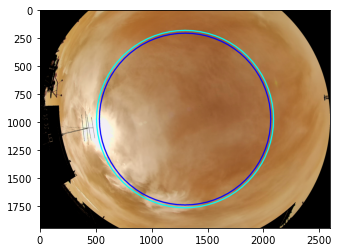

In [18]:
# Dibujo del cículo que pasa por el centroide, y por lo tanto, la elevación del sol(90 - zenit)
delta = np.array(centroide) - np.array(centro)
radio_imagen = int(np.linalg.norm(delta)) #Cáculo de la distancia entre el centroide y el centro de la imágen

# img_zenith es la imágen que contiene el radio correspondiente al zenith teórico
img_zeniths = img_zenith.copy()
cv2.circle(img_zeniths, centro, radio_imagen, color=(0,0,255), thickness=10)
plt.figure(1)
plt.imshow(img_zeniths)

R = int(Y/2)
diff_radio = radio_imagen - radio_teorico 
zenith_imagen = radio_imagen / R * 90
diff_angulo_zenith = diff_radio / R * 90
print('Zenith en la imagen: {:.2f}'.format(zenith_imagen))
print('Zenith teórico: {:.2f}'.format(zenith))
print('Diferencia en el radio: {}'.format(diff_radio))
print('Diferencia en el ángulo zenith: {:.2f}'.format(diff_angulo_zenith))

Azimuth en la imagen: 99.61
Azimuth teórico: 98.28
Diferencia en el ángulo azimuth: 1.33


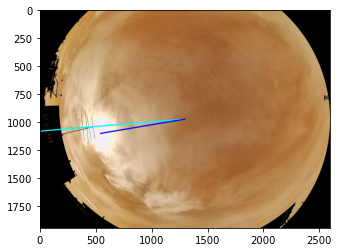

In [19]:
# Dibujo de la líena que pasa por el centroide y por el centro de la imagen, y por lo tanto, la orientación del sol(azimut)
img_azimuths = img_azimuth.copy()

# Azimuth
cv2.line(img_azimuths, centro, centroide, color=(0,0,255), thickness=10)
plt.figure(1)
plt.imshow(img_azimuths)

delta_x = delta[1]
delta_y = delta[0]

# Cáculo del ángulo azimutal
alpha = np.arctan(delta_x / delta_y) / np.pi * 180
if alpha <= 0: # Segundo o cuatro cuadrante
    if delta_x <= 0: # Cuarto cuadrante
        alpha = alpha
    else: # Segundo cuatrante
        alpha += 180
else: # Primer o tercer cuadrante
    if delta_x >= 0: # Primer cuadrante
        alpha = alpha
    else: # Tercer cuadrante
        alpha += 180
        
azimuth_imagen = 270 - alpha

diff_angulo_azimuth = azimuth_imagen - azimuth
print('Azimuth en la imagen: {:.2f}'.format(azimuth_imagen))
print('Azimuth teórico: {:.2f}'.format(azimuth))
print('Diferencia en el ángulo azimuth: {:.2f}'.format(diff_angulo_azimuth))

    Con una simple muestra no es posible detectar si la cámara apunta al zenith o presenta un desajuste, con lo que se ha decidido observar en una muestra de 1000 imagenes los errores que se producen entre los valores teóricos y medidos:

In [20]:
# Correción del ángulo zenital y azimutal
# Se han obtenido las singuientes funciones teniendo en cuente que la variable independiente es el ángulo azimutal,
# y las dependientes los errores del zenith y del azimuth, respectivamente.

# Función f(Azimuth) = E_Zenith'
f_e_zenith = np.poly1d([-2.39868262e-15,  3.50513843e-12, -2.21157550e-09,  7.85898258e-07,
       -1.71806653e-04,  2.36263063e-02, -1.99098375e+00,  9.35568351e+01,
       -1.86545096e+03])

# Función f(Azimuth) = E_Azimuth'
f_e_azimuth = np.poly1d([ 3.65988269e-15, -5.47496213e-12,  3.47014587e-09, -1.21189681e-06,
        2.54007293e-04, -3.26229416e-02,  2.50644795e+00, -1.05521493e+02,
        1.87232475e+03])

# La información con la que se han obtenido los datos se encuentra en:
# errores = pd.read_csv('errores.csv')

In [21]:
%%HTML
<img src="datos/f_e_azimuth.png"
     alt="f_e_azimuth"
     style="float: left; margin-right: 5px;" />
        
<img src="datos/f_e_zenith.png"
     alt="f_e_zenith"
     style="float: left; margin-right: 5px;" />

    Vemos que en ambas gráficas, error azimutal y error zenital, una relación que se puede comparar con una función relativamente sencilla. Sean o no dependientes de esto, podemos comentar también que en el caso de los ángulo azimutales estos presentan un error de hasta 30 grados, que es bastante significativo y que puede dar lugar a resultados lejanos a los reales. En cuanto al ángulo zenital, vemos que el ángulo error máximo es de unos 10 grados, manteniendose en la mayoria de casos en un margene de +- 5 grados.

   #### Porcentaje de cielo que se encuentra cubierto por nubes
    El ratio de cielo cubierto se realiza a partir de: máscara del cielo que podemos ver y la máscara de nubes que hemos obtenido con los métodos anteriores. Para el calculo de esta máscara se ha utilizado en método híbrido propuesto anteriormente.

La proporción de nubes en el cielo es de: 23.79%


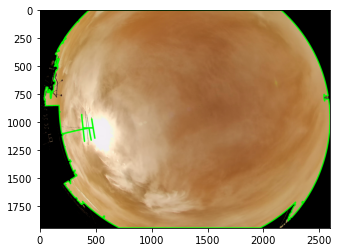

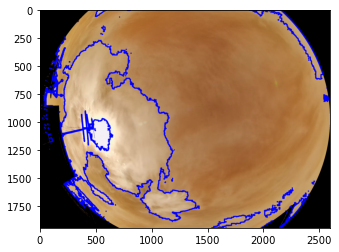

In [22]:
# Cálculo de porcentaje de cielo cubierto por nubes
# Se obtienen los contornos de la máscara de cielo
cnt_cielo, hierarchy = cv2.findContours(mask_cielo, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Se obtiene el contorno de mayor tamaño, y se obtiene su área, en este caso corresponde a la parte de cielo que podemos ver
area_cielo = 0
for cnt in cnt_cielo:
    A = cv2.contourArea(cnt)
    if A > area_cielo:
        area_cielo = A
        cnt_max = cnt

# Se muestra en pantalla el cielo visible rodeado por una línea verde, a modo de ejemplo
contorno_cielo = img_proc.copy()
cv2.drawContours(contorno_cielo, cnt_max, -1, (0, 255, 0), thickness=10)
plt.figure(1)
plt.imshow(contorno_cielo)

# Del mismo modo, se obtienen los contornos de la máscara de nubes, que correponderán a las nubes del cielo
cnt_nubes, hierarchy = cv2.findContours(mask_cloud, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# Cálculo del área de cielo tapado por nubes
area_nubes = 0
for cnt in cnt_nubes:
    area_nubes += cv2.contourArea(cnt)
    
# Se muestra en pantalla las nubes
nubes = img_proc.copy()
cv2.drawContours(nubes, cnt_nubes, -1, (0, 0, 255), thickness=10)
plt.figure(2)
plt.imshow(nubes)

# Cálculo del ratio nubes/ cielo visible
ratio_nubes = area_nubes / area_cielo * 100
print('La proporción de nubes en el cielo es de: {:.2f}%'.format(ratio_nubes))

## Trabajos en proceso
+ Desarrollo de un método fiable que pueda predecir si el sol está cubierto por nubes o no, en casos en los que las nubes son poco densas. Una idea en la que estoy trabajando es el cálculo de la circularidad, anteriormente mencionado. Otra posible aproximación es la detección de nubes a su alrededor: p.ej.: si se detecta en la máscara de nubes, que el sol está rodeado de nubes, se considera que esta tapado por la nubes. En este caso, se si el sol ha sido detectado, es porque son poco densas, en el caso de que no haya sido detectado es que son muy densas. A lo hora de calcular la radiación difusa, creo que es importante conocer algunas características de las nubes que rodean el sol.
+ Detección de nubes cercanas al sol cuando el cielo está totalmente despejado alrededor de este. Un problema que surge cuando el cielo está despejado es la detección de nubes cercanas al sol, esto se debe a que las zonas cercanas al sol se saturan en la imagen, modificando los umbrales de los métodos utilizados. Una posible solución es la detección, es el uso de la modelo HSV en el área cercana al sol, para detectar las circularidad del area saturada, en el caso de que tenga una circularidad alta, lo más probable es que no sea una nube, sino el sol totalmente descubierto. Con lo que, se podría deducir que la radiación difusa en este caso es ínfima, siendo la mayor parte de la radiación procedente del sol directa.

# Comentarios 
+ Sobre la relación entre los errores con el ángulo azimuth. No sé si se puede concluir que hay relación entre ambos, he realizado el estudio con 1000 imágenes tomadas, aproximadamente. Me gustaría saber vuestra opinión acerca de esto y si puedo utilizarlo durante el desarrollo del TFG o es algo incorrecto. Existe la posibilidad de ampliar el estudio con las imágenes que se han generado hasta el momento.
+ En el siguinete informe, tengo pensado proponer un algoritmo en que junta todos los métodos explicados, con el fin de obtener las variables que conformarán la ecuación con la que se estimaría la radiación difusa. Algunos de las variables que pueden afectar a la radiación obtenida son: ángulo zenith del sol, porcentaje de cielo cubierto, características de las nubes que rodean al sol, etc.
+ Posibilidad de implementación de algoritmo clasificador de nubes, debido a su importancia a la hora de interactuar con la radiación del sol.

# Bibliografía
#### Relación azimuth y zenith con las coordenadas de la imágen
    Axel Kreuter, Matthias Zangerl, Michael Schwarzmann, and Mario Blumthaler, "All-sky imaging: a simple, versatile system for atmospheric research," Appl. Opt. 48, 1091-1097 (2009)
    Yang, J., Min, Q., Lu, W., Yao, W., Ma, Y., Du, J., Lu, T., and Liu, G.: An automated cloud detection method based on the green channel of total-sky visible images, Atmos. Meas. Tech., 8, 4671–4679, https://doi.org/10.5194/amt-8-4671-2015, 2015.
    
#### Métodos de detección de nubes
    Yang, J., Min, Q., Lu, W., Yao, W., Ma, Y., Du, J., Lu, T., and Liu, G.: An automated cloud detection method based on the green channel of total-sky visible images, Atmos. Meas. Tech., 8, 4671–4679, https://doi.org/10.5194/amt-8-4671-2015, 2015.
    Cloud detection and classification with the use of whole-sky ground-based images, https://doi.org/10.1016/j.atmosres.2012.05.005
     Alonso-Montesinos, J.: Real time automatic cloud detection using a low-cost sky camera, Atmos. Meas. Tech. Discuss., https://doi.org/10.5194/amt-2019-484, 2020.
    